# 泊松融合

In [3]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
import scipy.spatial.distance
import scipy.signal
import skimage
import skimage.io
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.optimize import minimize
import math
import operator
import networkx as nx
import pdb
import itertools
from numba import jit

In [4]:
@jit
def computeAlphaJit(alpha, b, unknown):
    h, w = unknown.shape
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    alphaNew[i,j] = 1/4  * (alphaNew[i-1 ,j] + alphaNew[i,j-1] + alphaOld[i, j+1] + alphaOld[i+1,j] - b[i,j])
        n +=1
    return alphaNew

In [5]:
def poisson_matte(gray_img, trimap):
    h, w = gray_img.shape
    fg = trimap == 255
    bg = trimap == 0
    unknown = True ^ np.logical_or(fg,bg)
    fg_img = gray_img*fg
    bg_img = gray_img*bg
    alphaEstimate = fg + 0.5 * unknown

    approx_bg = cv2.inpaint(bg_img.astype(np.uint8),(unknown+fg).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(fg)).astype(np.float32)
    approx_fg = cv2.inpaint(fg_img.astype(np.uint8),(unknown+bg).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(bg)).astype(np.float32)

    # Smooth F - B image
    approx_diff = approx_fg - approx_bg
    approx_diff = scipy.ndimage.filters.gaussian_filter(approx_diff, 0.9)

    dy, dx = np.gradient(gray_img)
    d2y, _ = np.gradient(dy/approx_diff)
    _, d2x = np.gradient(dx/approx_diff)
    b = d2y + d2x

    alpha = computeAlphaJit(alphaEstimate, b, unknown)
    
    alpha = np.minimum(np.maximum(alpha,0),1).reshape(h,w)
    return alpha


In [7]:
def main():    
    img = scipy.misc.imread('../datas/troll.png')
    gray_img = scipy.misc.imread('../datas/troll.png', flatten='True')
    trimap = scipy.misc.imread('../datas/trollTrimap.bmp', flatten='True')

    alpha = poisson_matte(gray_img,trimap)

    plt.imshow(alpha, cmap='gray')
    plt.show()
    h, w, c = img.shape
    plt.imshow((alpha.reshape(h,w,1).repeat(3,2)*img).astype(np.uint8))
    plt.show()


C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


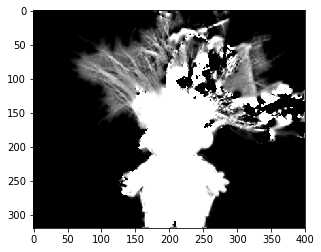

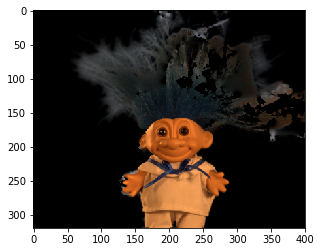

In [8]:
main()

参考：

[1]. https://github.com/MarcoForte/poisson-matting

[2]. https://blog.csdn.net/baimafujinji/article/details/6485778